In [81]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy

In [535]:
# formatting & aesthetics
font = {'family':'sans serif', 'size':10}
plt.rc('font', **font)
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.facecolor'] = 'white'
sns.set_style("white")

sns_pal = sns.color_palette('Set1', n_colors=8, desat=.4)
greys_pal = sns.color_palette('Greys', n_colors=9)

In [536]:
# class definition

class iteration:
    def __init__(self, last_year, capex, adaptex, # required inputs
                 damage_function,
                 randomize_insurance,
                 has_speedy_loan,
                 loan_term,
                 gamma,
                 avg_prod_k,
                 tax_rate,
                 fixed_spending_rate,
                 variable_spending_rate,
                 init_gdp,init_debt_over_gdp,
                 verbose):
    
        # Calibration parameters      
        # Saving to self, because these can't be changed after initialization
        self.randomize_insurance = randomize_insurance
        self.damage_function = damage_function
        self.has_speedy_loan = has_speedy_loan
        self.loan_term = loan_term
        self.loan_interest_rate = 0.00
        self.gamma = gamma # capital stock decay
        self.avg_prod_k = avg_prod_k # average productivity of capital
        self.tax_rate = tax_rate # fraction of total capital productivity
        self.fixed_spending_rate = fixed_spending_rate # this is constant, and in currency units, no dependence on GDP
        self.variable_spending_rate = variable_spending_rate # this is spending that scales with GDP, as % of GDP 
        self.verbose = verbose
        
        # additional annual exogenous
        self.capex = capex
        self.adaptex = adaptex
                        
        # Annual endogenous
        self.update_stocks(last_year,init_gdp,init_debt_over_gdp) 
        # also updating debt interest rate here
        
        # Disaster!!!
        # 1) Apply damage function
        self.get_return_period()
        self.get_damages()
        
        # 2) Get cost of PDS, triggered by shock:
        self.get_pds_cost()
        
        # 3) Loans
        self.trigger_loans()
        
        # 4) Insurance
        self.check_insurance_policy(markup=0.3)
        
        # 5) adjust capital
        self.assess_damages()
         
        # WRAP UP:    
        # update the finances
        self.update_accounts()
        
        
        
        
    #################################
    # Component functions
    def update_stocks(self,last_year,init_gdp,init_debt_over_gdp):
        try: 
            self.year = last_year.year+1
            self.gdp = last_year.gdp # pass from last year, will be recalculated net of everything each year 
            #
            self.loan_debt = last_year.loan_debt*(1+self.loan_interest_rate)
            #
            self.capstock = last_year.capstock*(1-self.gamma) + self.capex
            self.adaptstock = last_year.adaptstock*(1-self.gamma) + self.adaptex
            self.gen_debt = last_year.gen_debt*(1+self.get_debt_interest_rate(last_year))            
        except:
            if last_year is not None: assert False
            self.initialize_stocks(init_gdp,init_debt_over_gdp)
        return True
    
    
    def get_debt_interest_rate(self,last_year):
        # 2nd term is about 0.5 when debt/gdp = 0.6
        return max(0.025,0.03*math.log(1+(last_year.gen_debt+last_year.loan_debt)/last_year.gdp))
    
    
    def initialize_stocks(self,init_gdp,init_debt_over_gdp):
        self.year = 0
        self.gdp = init_gdp
        self.capstock = self.gdp/self.avg_prod_k
        self.adaptstock = 0
        self.gen_debt = init_debt_over_gdp*self.gdp
        self.loan_debt = 0
        return True
    
    
    def get_return_period(self):
        # setup exceedance curve
        self.all_rps = [1,5,10,25,50,100]
        
        rand = np.random.uniform(0,1)
        if rand >= 0.99: self.return_period = 100
        elif rand >= 0.98: self.return_period = 50
        elif rand >= 0.95: self.return_period = 25
        elif rand >= 0.90: self.return_period = 10
        elif rand >= 0.80: self.return_period = 5
        else: self.return_period = 1
        return True
            
        
    def get_damages(self):
                
        if self.damage_function == 'EP': 
             
            # capital vulnerability
            self.cap_vul = {1:0.01, 5:0.02, 10:0.04, 25:0.08, 50:0.16, 100:0.20}
            
            # adaptive infrastructure
            # --> think of this as building to a standard..but how to link to adaptive infra stock?
            # --> protection linked to % of capital stock -- check Lifelines
            frac_adapt = self.adaptstock/self.capstock
            #                                            1      5      10      25      50      100
            if   frac_adapt >= 0.100: self.protection = {1:0.0, 5:0.0, 10:0.0, 25:0.2, 50:0.4, 100:0.8}
            elif frac_adapt >= 0.050: self.protection = {1:0.0, 5:0.0, 10:0.2, 25:0.6, 50:0.8, 100:1.0}
            elif frac_adapt >= 0.025: self.protection = {1:0.0, 5:0.2, 10:0.9, 25:1.0, 50:1.0, 100:1.0}
            elif frac_adapt >= 0.010: self.protection = {1:0.2, 5:0.6, 10:1.0, 25:1.0, 50:1.0, 100:1.0}
            else: self.protection = {1:1.0, 5:1.0, 10:1.0, 25:1.0, 50:1.0, 100:1.0}
            #
            self.damage_fraction = self.cap_vul[self.return_period]*self.protection[self.return_period]
            #
            
        elif self.damage_function is not None: 
            try: self.damage_fraction = float(self.damage_function)
            except: self.damage_fraction = 0
        else: self.damage_fraction = 0
        return True
    
    
    def get_aal_fraction(self,min_shock_covered):
        aal = 0 # this is not a component of the class because it will be recalculated as function of RP
        
        for nrp, rp in enumerate(self.all_rps):
            if rp < min_shock_covered: continue
            if rp != self.all_rps[-1]: aal += (1/rp-1/self.all_rps[nrp+1])*self.cap_vul[rp]*self.protection[rp]
            else: aal += (1/rp)*self.cap_vul[rp]*self.protection[rp]
        return aal
            
        
    def get_pds_cost(self):
        if self.return_period > 1:
            self.pds_cost = 0.05*self.capstock*self.damage_fraction*self.avg_prod_k
        else: self.pds_cost = 0
            
            
    def trigger_loans(self):
        self.loan_value = 0
        
        if self.return_period >= 1 and self.has_speedy_loan:
            self.loan_value = 0.02*self.damage_fraction*self.capstock
            self.loan_debt += self.loan_value
        
            
    def check_insurance_policy(self,markup=0.3):
        self.is_insured = False
        self.insurance_premium = 0.
        self.insurance_payout = 0
        
        # insurance is random, or it's off
        if not self.randomize_insurance: 
            return False
        
        # 50% of simulations take insurance
        if np.random.randint(2) == 1:
            
            self.is_insured = True
            
            # another random number to decide what level of coverage they selected...rp >= random level greater than 1
            min_shock_covered = self.all_rps[np.random.randint(1,len(self.all_rps))]
            
            # third random number to decide what fraction of losses are covered:
            fraction_damages_covered = 1E-1*np.random.randint(1,6)
            
            # expected losses plus markup
            self.insurance_premium = (self.get_aal_fraction(min_shock_covered)*self.capstock
                                      *fraction_damages_covered
                                      *(1+markup))

            # does policy pay out?
            if min_shock_covered <= self.return_period: 
                self.insurance_payout = self.capstock*self.damage_fraction*fraction_damages_covered
                if self.year < 3 and self.return_period >= 50 and self.verbose:
                    out_str = 'Premium = ${} (rp >={} + {}% of ExpL). Actual RP = {}; Value = ${}. GDP = {}; Debt = {}.'
                    print(out_str.format(round(self.insurance_premium,1),
                                         min_shock_covered,int(1E2*fraction_damages_covered),
                                         self.return_period,
                                         round(self.insurance_payout,1),
                                         round(self.gdp),
                                         round(self.gen_debt)))
        return True  
    
    
    def assess_damages(self):
        self.capstock = self.capstock*(1-self.damage_fraction)+self.loan_value
        self.adaptstock *= (1-self.damage_fraction)
        self.capout = self.capstock*self.avg_prod_k   
        return True
    
    
    def update_accounts(self):
        self.gov_revenue = self.capout*self.tax_rate + self.insurance_payout + self.loan_value
        self.gov_expenditures = (self.fixed_spending_rate 
                                + self.variable_spending_rate*self.capout
                                + self.capex + self.adaptex + self.pds_cost
                                + self.insurance_premium
                                + self.loan_value + (1/self.loan_term)*self.loan_debt)
        self.gdp = self.capout + self.gov_expenditures - self.gov_revenue
        #
        self.gen_debt += self.gov_expenditures - self.gov_revenue
        self.loan_debt *= (self.loan_term-1)/self.loan_term
        self.total_debt = self.gen_debt+self.loan_debt
        return True
            
        
    def refresh(self,_yr, capex=0, adaptex=0):
        return iteration(_yr, capex, adaptex, 
                         damage_function=_yr.damage_function,
                         randomize_insurance=_yr.randomize_insurance,
                         has_speedy_loan=_yr.has_speedy_loan,
                         loan_term = _yr.loan_term,
                         gamma=_yr.gamma,
                         avg_prod_k=_yr.avg_prod_k,
                         tax_rate=_yr.tax_rate,
                         fixed_spending_rate=_yr.fixed_spending_rate,
                         variable_spending_rate=_yr.variable_spending_rate,
                         init_gdp=None,init_debt_over_gdp=None,
                         verbose=_yr.verbose)

In [537]:
# class definition

class sequence:
    def __init__(self,seed):
        
        # Fixed parameters 
        self.gamma = seed.gamma # capital stock decay
        self.avg_prod_k = seed.avg_prod_k # average productivity of capital
        self.tax_rate = seed.tax_rate # fraction of total factor productivity
        
        # initialize series
        self.initialize_simulation()
        self.append(seed)
        
        
    def initialize_simulation(self):
        # Annual series
        self.year = []
        self.capstock = []
        self.capex = []
        self.adaptstock = []
        self.adaptex = []
        self.gdp = []
        self.gov_revenue = []
        self.gov_expenditures = []
        self.total_debt = []
        self.debt_over_gdp = []
        
                        
    def append(self,iteration):
        self.check_consistency(iteration)
        
        # Annual series
        self.year.append(iteration.year)
        self.capstock.append(iteration.capstock)
        self.adaptstock.append(iteration.adaptstock)
        self.capex.append(iteration.capex)
        self.adaptex.append(iteration.adaptex)
        #
        self.gdp.append(iteration.gdp)
        self.gov_revenue.append(iteration.gov_revenue)
        self.gov_expenditures.append(iteration.gov_expenditures)
        self.total_debt.append(iteration.total_debt)
        self.debt_over_gdp.append(1E2*iteration.total_debt/iteration.gdp)
        
    def check_consistency(self,iteration):
        assert(self.gamma==iteration.gamma)
        assert(self.avg_prod_k==iteration.avg_prod_k)
        assert(self.tax_rate==iteration.tax_rate)
        return True
    
    def initialize_store(self):
        self.en_capstock = pd.DataFrame(list(zip(self.year,self.capstock)),columns=['year','sim_0']).set_index('year').T
        self.en_adaptstock = pd.DataFrame(list(zip(self.year,self.adaptstock)),columns=['year','sim_0']).set_index('year').T
        self.en_capex = pd.DataFrame(list(zip(self.year,self.capex)),columns=['year','sim_0']).set_index('year').T
        self.en_adaptex = pd.DataFrame(list(zip(self.year,self.adaptex)),columns=['year','sim_0']).set_index('year').T
        #
        self.en_gdp = pd.DataFrame(list(zip(self.year,self.gdp)),columns=['year','sim_0']).set_index('year').T
        self.en_gov_revenue = pd.DataFrame(list(zip(self.year,self.gov_revenue)),columns=['year','sim_0']).set_index('year').T
        self.en_gov_expenditures = pd.DataFrame(list(zip(self.year,self.gov_expenditures)),columns=['year','sim_0']).set_index('year').T
        self.en_total_debt = pd.DataFrame(list(zip(self.year,self.total_debt)),columns=['year','sim_0']).set_index('year').T
        self.en_debt_over_gdp = pd.DataFrame(list(zip(self.year,self.debt_over_gdp)),columns=['year','sim_0']).set_index('year').T
        return True
    
    def store(self,n):
        try:        
            self.en_capstock = self.en_capstock.append(pd.Series(self.capstock,index=self.year).to_frame(name='sim_{}'.format(n)).T)
            self.en_adaptstock = self.en_adaptstock.append(pd.Series(self.adaptstock,index=self.year).to_frame(name='sim_{}'.format(n)).T)
            self.en_capex = self.en_capstock.append(pd.Series(self.capex,index=self.year).to_frame(name='sim_{}'.format(n)).T)
            self.en_adaptex = self.en_adaptstock.append(pd.Series(self.adaptex,index=self.year).to_frame(name='sim_{}'.format(n)).T)
            #
            self.en_gdp = self.en_gdp.append(pd.Series(self.gdp,index=self.year).to_frame(name='sim_{}'.format(n)).T)
            self.en_gov_revenue = self.en_gov_revenue.append(pd.Series(self.gov_revenue,index=self.year).to_frame(name='sim_{}'.format(n)).T)        
            self.en_gov_expenditures = self.en_gov_expenditures.append(pd.Series(self.gov_expenditures,index=self.year).to_frame(name='sim_{}'.format(n)).T)        
            self.en_total_debt = self.en_total_debt.append(pd.Series(self.total_debt,index=self.year).to_frame(name='sim_{}'.format(n)).T)        
            self.en_debt_over_gdp = self.en_debt_over_gdp.append(pd.Series(self.debt_over_gdp,index=self.year).to_frame(name='sim_{}'.format(n)).T)        
        except: self.initialize_store()
            
        self.dump_simulation()
        return True
    
    def dump_simulation(self):
        self.year_list = self.year
        self.initialize_simulation()
        
    def dump_store(self):
        self.initialize_store()
        
    def get_summary_stats(self):
        #
        self.mean_capstock = self.en_capstock.mean(axis=0)
        self.mean_adaptstock = self.en_adaptstock.mean(axis=0)
        self.mean_capex = self.en_capex.mean(axis=0)
        self.mean_adaptex = self.en_adaptex.mean(axis=0)

        self.mean_gdp = self.en_gdp.mean(axis=0)
        self.mean_gov_revenue = self.en_gov_revenue.mean(axis=0)
        self.mean_gov_expenditures = self.en_gov_expenditures.mean(axis=0)
        self.mean_total_debt = self.en_total_debt.mean(axis=0)
        self.mean_debt_over_gdp = self.en_debt_over_gdp.mean(axis=0)
        #
        self.std_capstock = self.en_capstock.std(axis=0)
        self.std_adaptstock = self.en_adaptstock.std(axis=0)
        self.std_capex = self.en_capex.std(axis=0)
        self.std_adaptex = self.en_adaptex.std(axis=0)
        
        self.std_gdp = self.en_gdp.std(axis=0)
        self.std_gov_revenue = self.en_gov_revenue.std(axis=0)
        self.std_gov_expenditures = self.en_gov_expenditures.std(axis=0)
        self.std_total_debt = self.en_total_debt.std(axis=0)
        self.std_debt_over_gdp = self.en_debt_over_gdp.std(axis=0)       
        #        
        self.gdp_growth = round(1E2*(math.exp(math.log(float(self.mean_gdp.iloc[-1]/self.mean_gdp.iloc[0]))/len(self.year_list))-1),2)
        #
        self.mean_confidence_interval(confidence=0.95)
        return True
    
    def mean_confidence_interval(self, confidence):
        # below assumes normal distribution, but it's not symmetric

        # method A: don't divide by sqrt(nsims)
        self.ci95_lo_debt_over_gdp = (self.mean_debt_over_gdp - 1.96*self.std_debt_over_gdp)
        self.ci95_hi_debt_over_gdp = (self.mean_debt_over_gdp + 1.96*self.std_debt_over_gdp)

        self.ci95_lo_capstock = (self.mean_capstock - 1.96*self.std_capstock)
        self.ci95_hi_capstock = (self.mean_capstock + 1.96*self.std_capstock)
        
        # method B:
        #self.ci95_hi_debt_over_gdp = (self.mean_debt_over_gdp + 1.96*self.std_debt_over_gdp)#/math.sqrt(nsim_tot))
        
        # method C
        
        #ci_lo, ci_hi = [],[]
        #nsim_tot = self.en_debt_over_gdp.shape[0]
        
        #for _yr in self.year_list:
            
        #    a = 1.0 * np.array(self.en_debt_over_gdp[_yr])
        #    m, se = np.mean(a), scipy.stats.sem(a)
        #    h = se * scipy.stats.t.ppf((1 + confidence) / 2., nsim_tot-1)
        #    ci_lo.append(m-h)
        #    ci_hi.append(m+h)
        
        #self.ci95_lo_debt_over_gdp = ci_lo
        #self.ci95_hi_debt_over_gdp = ci_hi
        

In [538]:
def run_model(capex_frac_gdp,
              adaptex_frac_gdp,
              damage_function='EP',
              randomize_insurance=True,
              has_speedy_loan=True,
              loan_term=30,
              gamma=0.05,
              avg_prod_k=0.35,
              tax_rate=0.30,
              fixed_spending_rate=0.0,
              variable_spending_rate=0.0,
              init_gdp=100,
              init_debt_over_gdp=0.5,
              nsim=250,
              nyears=80,
              plot_opts=None,
              verbose=False):

    # initialize
    aYear = iteration(None,0,0,damage_function,randomize_insurance,has_speedy_loan,loan_term,gamma,avg_prod_k,tax_rate,
                      fixed_spending_rate,variable_spending_rate,init_gdp,init_debt_over_gdp,verbose)
    
    summary = sequence(aYear)

    n = 0
    while n < nsim:

        # Run simulation
        while aYear.year < nyears:

            aYear = aYear.refresh(aYear,
                                  capex=aYear.gdp*capex_frac_gdp,#=aYear.capstock*(aYear.gamma+aYear.damage_fraction),
                                  adaptex=aYear.gdp*adaptex_frac_gdp)#aYear.capstock*adaptex_frac_capstock)
            summary.append(aYear)
        
        # Plot
        if plot_opts is not None:
            _str, _col = plot_opts
            plt.plot(summary.year,getattr(summary,_str),color=_col,lw=1.0,alpha=0.90,zorder=90)
    
        # save simulation results into store
        # NB: this also flushes simulation
        summary.store(n)
    
        # reset simulation
        aYear = iteration(None,0,0,damage_function,randomize_insurance,has_speedy_loan,loan_term,gamma,avg_prod_k,tax_rate,
                          fixed_spending_rate,variable_spending_rate,init_gdp,init_debt_over_gdp,verbose)
        summary.append(aYear)
        n+= 1

    summary.get_summary_stats()
    return summary


In [539]:
# run 2 scenarios

baseline = run_model(capex_frac_gdp=0.30,
                     adaptex_frac_gdp=0.0,
                     has_speedy_loan=False,
                     fixed_spending_rate=5,
                     plot_opts=None,#('debt_over_gdp',greys_pal[2]),
                     verbose=False)
print('GDP growth of {}% per year in baseline scenario.'.format(baseline.gdp_growth))

invest_scenario = run_model(capex_frac_gdp=0.30,
                            adaptex_frac_gdp=0.005,
                            fixed_spending_rate=5,
                            has_speedy_loan=False,
                            plot_opts=None)
print('GDP growth of {}% per year in investment scenario.'.format(invest_scenario.gdp_growth))

invest_loan_scenario = run_model(capex_frac_gdp=0.30,
                                 adaptex_frac_gdp=0.005,
                                 fixed_spending_rate=5,
                                 plot_opts=None)
print('GDP growth of {}% per year in investment + loan scenario.'.format(invest_loan_scenario.gdp_growth))

#plt.ylim(-200,200)
#plt.show()

GDP growth of 3.95% per year in baseline scenario.
GDP growth of 4.7% per year in investment scenario.
GDP growth of 4.68% per year in investment + loan scenario.


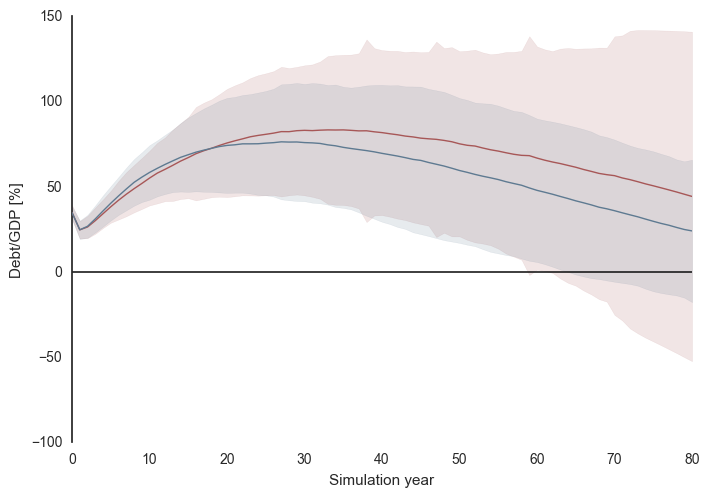

In [540]:
# plot GDP/debt
#plt.plot(baseline.year_list,baseline.mean_total_debt,color=sns_pal[3],lw=1,zorder=99,label='debt')
#plt.plot(baseline.year_list,baseline.mean_gdp,color=sns_pal[4],lw=1,zorder=99,label='gdp')

plt.plot(baseline.year_list,baseline.mean_debt_over_gdp,color=sns_pal[0],lw=1,zorder=99)
plt.fill_between(baseline.year_list,
                 baseline.ci95_lo_debt_over_gdp,
                 baseline.ci95_hi_debt_over_gdp,color=sns_pal[0],alpha=0.15)
    
plt.plot(invest_scenario.year_list,invest_scenario.mean_debt_over_gdp,color=sns_pal[1],lw=1,zorder=99)
plt.fill_between(invest_scenario.year_list,
                 invest_scenario.ci95_lo_debt_over_gdp,
                 invest_scenario.ci95_hi_debt_over_gdp,color=sns_pal[1],alpha=0.15)     
    
sns.despine(bottom=True)
plt.plot([0,80],[0,0],color=greys_pal[8],lw=1.2,zorder=1)

plt.xlabel('Simulation year')
plt.ylabel('Debt/GDP [%]')
#plt.legend()

#plt.ylim(-200,200)
plt.gcf().savefig('plots/debt_over_gdp_adaptex.pdf',format='pdf',bbox_inches='tight')
plt.show()
plt.cla()


In [541]:
#Above: 
# red simulations invest 5% of capital on capex, nothing on disaster mitigation
# blue simulations invest 5% of capital on capex, plus 1% of GDP each year in DRR infrastructure 

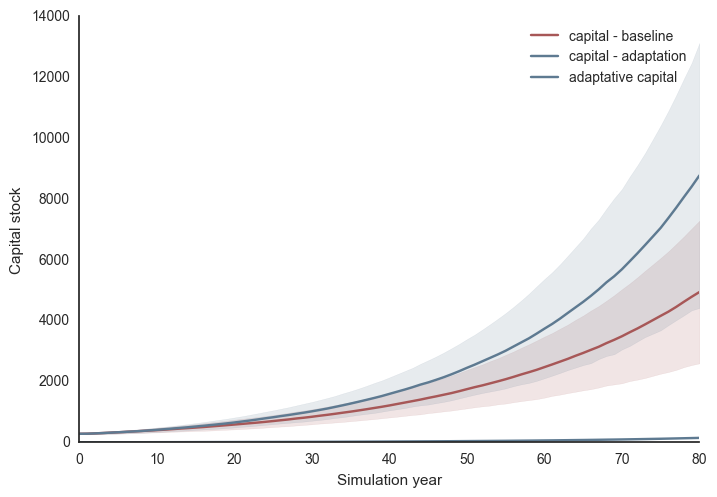

In [542]:
# Plot capital stock

ax = plt.plot(baseline.year_list,baseline.mean_capstock,color=sns_pal[0],label='capital - baseline')
plt.plot(invest_scenario.year_list,invest_scenario.mean_capstock,color=sns_pal[1],label='capital - adaptation')

#plt.plot(baseline.year_list,baseline.mean_adaptstock,color=sns_pal[0],label='adaptive capital - baseline')
plt.plot(invest_scenario.year_list,invest_scenario.mean_adaptstock,color=sns_pal[1],label='adaptative capital')

plt.fill_between(baseline.year_list,
                 baseline.ci95_lo_capstock,
                 baseline.ci95_hi_capstock,color=sns_pal[0],alpha=0.15)  
plt.fill_between(invest_scenario.year_list,
                 invest_scenario.ci95_lo_capstock,
                 invest_scenario.ci95_hi_capstock,color=sns_pal[1],alpha=0.15)  
plt.legend()

sns.despine()
plt.grid(False)

if min(baseline.total_debt) > 0: plt.ylim(0)
else: 
    plt.plot([0,100],[0,0],color=greys_pal[8],lw=1.2,zorder=1)
    sns.despine(bottom=True)
    
plt.xlim(0,80)
    
plt.xlabel('Simulation year')
plt.ylabel('Capital stock')

plt.gcf().savefig('plots/capital.pdf',format='pdf',bbox_inches='tight')
plt.show()
plt.cla()